# Multi-label classification model

The model aims to classify the transcripts' sentences that belong to three different international courts.

The dataset that is considered for this project can be found at: TBD

The procedure followed to extract such sentences is described as follows:
- Relevant cases were chosen directly from the webpage of each international court
- Each transcript has a different format file (*.pdf, *.doc, or *.htm{( )|l}) and a cleaning process was applied in order to remove either uninformative or irrelevant information for the classification model
- Each cleaned transcript version was stored into a .txt file
- a
- b
- etc. 

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [87]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt

import src.multi_label_classif_model_utilities as mlclassif_utilities

## Globals

In [80]:
PATH_DATASET = "input/dataset/Dataset.xlsx"
INDEX_COLUMNS_DATASET = 0
LIST_NAME_COLUMNS_DATASET = ["span", "role", "trauma", "court"]

GLB_RETURN_ATTENTION_MASK = True

## Dataset

In [4]:
df_dataset = mlclassif_utilities.import_dataset_from_excel(PATH_DATASET, INDEX_COLUMNS_DATASET, LIST_NAME_COLUMNS_DATASET)
df_dataset.head()

,span,role,trauma,court
0,P R O C E E D I N G S\n(Judges enter courtroom)\n,Court Proceedings,0,ECCC
1,MR. PRESIDENT:\nPlease be seated. The Court i...,Judge,0,ECCC
2,"MS. STUDZINSKY:\nMr. President, good morning. ...",Lawyer,0,ECCC
3,I would like to have the following information...,Lawyer,0,ECCC
4,"MR. WERNER:\nMr. President, just to inform you...",Lawyer,0,ECCC


In [5]:
classes_dataset = mlclassif_utilities.get_unique_values_from_dataset(df_dataset, "role")
print(f"Num of different roles in the dataset is {len(classes_dataset)} which are:")
for index, elem in enumerate(classes_dataset):
    print("\t", index+1, "-", elem)
    
courts_dataset = mlclassif_utilities.get_unique_values_from_dataset(df_dataset, "court")
print(f"Num of different courts in the dataset is {len(courts_dataset)} which are:")
for index, elem in enumerate(courts_dataset):
    print("\t", index+1, "-", elem)

Num of different roles in the dataset is 5 which are:
	 1 - Court Proceedings
	 2 - Judge
	 3 - Lawyer
	 4 - Witness
	 5 - Accused
Num of different courts in the dataset is 2 which are:
	 1 - ECCC
	 2 - ICTY


### Distribution of all classes within the dataset

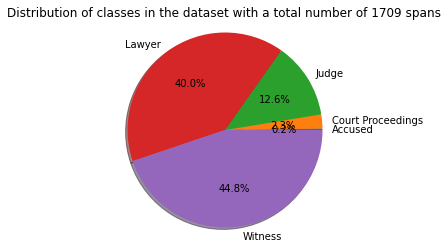

,role,span
0,Accused,4
1,Court Proceedings,40
2,Judge,216
3,Lawyer,683
4,Witness,766


In [43]:
distribution_classes = mlclassif_utilities.get_distribution_classes_from_dataset(df_dataset, ["role"], "span")

labels = list(distribution_classes["role"])
sizes = list(distribution_classes["span"])

fig1, ax1 = plt.subplots()
ax1.set_title(f'Distribution of classes in the dataset with a total number of {distribution_classes["span"].sum()} spans')
ax1.pie(sizes, labels=labels, autopct='%2.1f%%', shadow=True, startangle=0) #'%1.1f%%'
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

distribution_classes

## Setup

### Device

Get the GPU device if exists, otherwise get the cpu as default dev.

In [19]:
device = mlclassif_utilities.get_gpu_device_if_exists()

print(f"\n\n==> Selected device is '{device}' <==")

There are 1 GPU(s) available.

These are the available devices:
	 1 - NVIDIA GeForce GTX 1660 Ti


==> Selected device is 'cuda' <==


## Model

### Tokenizer

In [55]:
#If no parameters are sent, default values are considered. 
#    IDModel:      Bert
#    Model namel:  bert-base-uncased
#    Do uncase:    True

tokenizer = mlclassif_utilities.get_tokenizer() 

Loading BERT tokenizer...
Bert tokenizer was loaded successfully (bert-base-uncased) 
	 do_lower_case=True


### Get list of all sentences and all classes

In [48]:
list_all_spans = list(df_dataset["span"])
list_all_classes = list(df_dataset["role"])

### Max length of a sentence among all sentences within the dataset

In [54]:
mlclassif_utilities.get_max_length_of_a_sentence_among_all_sentences(tokenizer, list_all_spans, False)

Max sentence length:  568 found at index 37 . Sentence is:


 Then they started to interrogate me and beat me up.  It was --
the interrogation location was in a house outside the compound.
It was behind the Building A.  They cut me and they asked me to
lie down on the floor with my face facing down and they had a
bunch of sticks and they dropped it on the floor and it made
noise.  And I was asked to choose which stick I preferred.  And I
responded, "Whichever stick I choose, it is still a stick that
you will use to beat me up so it is up to you, Brother, to decide
which one you want to use."
Mam Nai stood up and grabbed a stick and started to beat me up.
After he felt exhausted, then another person came to take turn to
beat me up.  So that Mam Nai was Mam Nai alias Chan.  He got his
skin condition with a spotty skins and quite a red in his face.
He asked me to count the lashes and when I counted up to 10
lashes, he said, "How come you count to 10 lashes?  I only beat
you for one lash."

568

### Tokenize sentences

In [60]:
# If _return_attention_mask, a tuple of two lists is given (tensor_of_inputs, tensor_of_attention_masks)
all_spans_tokenized = mlclassif_utilities.get_all_spans_tokenized(
    mlclassif_utilities.GLB_BERT_MODEL_ID, 
    tokenizer,
    list_all_spans,
    _add_special_tokens = True, 
    _max_length = 512,
    _pad_to_max_length = True,
    _return_attention_mask = GLB_RETURN_ATTENTION_MASK, 
    type_tensors = mlclassif_utilities.GLB_PYTORCH_TENSOR_TYPE
)

In [85]:
input_ids = None
attention_masks = None

if GLB_RETURN_ATTENTION_MASK:
    input_ids = mlclassif_utilities.convert_list_into_pytorch_tensor(all_spans_tokenized[0])
    attention_masks = mlclassif_utilities.convert_list_into_pytorch_tensor(all_spans_tokenized[1])
else:
    input_ids = mlclassif_utilities.convert_list_into_pytorch_tensor(all_spans_tokenized)

### Split dataset

In [86]:
numeric_classes = mlclassif_utilities.convert_list_span_classes_into_numeric_values(classes_dataset, list_all_classes)
numeric_classes = mlclassif_utilities.convert_list_labels_into_pytorch_tensor(numeric_classes)

In [105]:
### Split dataset
train_labels_corpus, train_input_ids, train_attention_masks, val_labels_corpus, val_input_ids, val_attention_masks, test_labels_corpus, test_input_ids, test_attention_masks = mlclassif_utilities.split_dataset_train_val_test(numeric_classes, input_ids, attention_masks)

CORPUS TRAINING AND VALIDATION:  
	 Length labels 1623 
	 Length input_ids 1623 
	 Length attention_masks 1623 

	CORPUS TRAINING:  
		 Length labels 1460 
		 Length input_ids 1460 
		 Length attention_masks 1460
	CORPUS VALIDATION:  
		 Length labels 163 
		 Length input_ids 163 
		 Length attention_masks 163

CORPUS TEST:  
	 Length labels 86 
	 Length input_ids 86 
	 Length attention_masks 86 

